In [1]:
'''
MIT License
Copyright (c) 2019 Fanjin Zeng
This work is licensed under the terms of the MIT license, see <https://opensource.org/licenses/MIT>.

Notes:
	How often to plan a new route?
	-When a new obstacle data comes from octomap
		-When endpoint is determined to be inside of an obstacle
	-When the drone reaches the endpoint
	
	How to determine z dimension?
	-Fly at the height neccessary to keep the drone in the vertical center of the camera FOV
		-Need to know camera FOV
	
	-Need to find a step size and iteration number that works for the competition environment
	
	Need to be set up for arbitrary obstacle shapes instead of just circles
	-Could try making lines that are offset from the obstacle, then check for intersections
		-Would need to extend lines so that they intersect at corners
	
	Needed inputs from rover tracking:
	-Current rover position and velocity
	-Velocity calculated using positions over time
'''

'\nMIT License\nCopyright (c) 2019 Fanjin Zeng\nThis work is licensed under the terms of the MIT license, see <https://opensource.org/licenses/MIT>.\n\nNotes:\n\tHow often to plan a new route?\n\t-When a new obstacle data comes from octomap\n\t\t-When endpoint is determined to be inside of an obstacle\n\t-When the drone reaches the endpoint\n\t\n\tHow to determine z dimension?\n\t-Fly at the height neccessary to keep the drone in the vertical center of the camera FOV\n\t\t-Need to know camera FOV\n\t\n\t-Need to find a step size and iteration number that works for the competition environment\n\t\n\tNeed to be set up for arbitrary obstacle shapes instead of just circles\n\t-Could try making lines that are offset from the obstacle, then check for intersections\n\t\t-Would need to extend lines so that they intersect at corners\n\t\n\tNeeded inputs from rover tracking:\n\t-Current rover position and velocity\n\t-Velocity calculated using positions over time\n'

In [2]:
import numpy as np
from random import random
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from collections import deque

In [3]:
class Line():
  ''' Define line '''
  def __init__(self, p0, p1):
        self.p = np.array(p0)
        self.dirn = np.array(p1) - np.array(p0)
        self.dist = np.linalg.norm(self.dirn)
        self.dirn /= self.dist # normalize

  def path(self, t):
        return self.p + t * self.dirn



In [4]:
def Intersection(line, center, radius):
	''' Check line-sphere (circle) intersection '''
	a = np.dot(line.dirn, line.dirn)
	b = 2 * np.dot(line.dirn, line.p - center)
	c = np.dot(line.p - center, line.p - center) - radius * radius

	discriminant = b * b - 4 * a * c
	if discriminant < 0:
		return False

	t1 = (-b + np.sqrt(discriminant)) / (2 * a);
	t2 = (-b - np.sqrt(discriminant)) / (2 * a);

	if (t1 < 0 and t2 < 0) or (t1 > line.dist and t2 > line.dist):
		return False

	return True



def distance(x, y):
	return np.linalg.norm(np.array(x) - np.array(y))


def isInObstacle(vex, obstacles, radius):
	for obs in obstacles:
		if distance(obs, vex) < radius:
			return True
	return False


def isThruObstacle(line, obstacles, radius):
	for obs in obstacles:
		if Intersection(line, obs, radius):
			return True
	return False


def nearest(G, vex, obstacles, radius):
	Nvex = None
	Nidx = None
	minDist = float("inf")

	for idx, v in enumerate(G.vertices):
		line = Line(v, vex)
		if isThruObstacle(line, obstacles, radius):
			continue

		dist = distance(v, vex)
		if dist < minDist:
			minDist = dist
			Nidx = idx
			Nvex = v

	return Nvex, Nidx


def newVertex(randvex, nearvex, stepSize):
	dirn = np.array(randvex) - np.array(nearvex)
	length = np.linalg.norm(dirn)
	dirn = (dirn / length) * min (stepSize, length)

	newvex = (nearvex[0]+dirn[0], nearvex[1]+dirn[1])
	return newvex


def window(startpos, endpos):
	''' Define seach window - 2 times of start to end rectangle '''
	width = endpos[0] - startpos[0]
	height = endpos[1] - startpos[1]
	winx = startpos[0] - (width / 2.)
	winy = startpos[1] - (height / 2.)
	return winx, winy, width, height


def isInWindow(pos, winx, winy, width, height):
	''' Restrict new vertex insides search window '''
	if winx < pos[0] < winx+width and \
		winy < pos[1] < winy+height:
		return True
	else:
		return False


In [5]:
class Graph:
	''' Define graph '''
	def __init__(self, startpos, endpos):
		self.startpos = startpos
		self.endpos = endpos

		self.vertices = [startpos]
		self.edges = []
		self.success = False

		self.vex2idx = {startpos:0}
		self.neighbors = {0:[]}
		self.distances = {0:0.}

		self.sx = endpos[0] - startpos[0]
		self.sy = endpos[1] - startpos[1]

	def add_vex(self, pos):
		try:
			idx = self.vex2idx[pos]
		except:
			idx = len(self.vertices)
			self.vertices.append(pos)
			self.vex2idx[pos] = idx
			self.neighbors[idx] = []
		return idx

	def add_edge(self, idx1, idx2, cost):
		self.edges.append((idx1, idx2))
		self.neighbors[idx1].append((idx2, cost))
		self.neighbors[idx2].append((idx1, cost))


	def randomPosition(self):
		rx = random()
		ry = random()

		posx = self.startpos[0] - (self.sx / 2.) + rx * self.sx * 2
		posy = self.startpos[1] - (self.sy / 2.) + ry * self.sy * 2
		return posx, posy

In [6]:
def RRT(startpos, endpos, obstacles, n_iter, radius, stepSize):
	''' RRT algorithm '''
	G = Graph(startpos, endpos)

	for _ in range(n_iter):
		randvex = G.randomPosition()
		if isInObstacle(randvex, obstacles, radius):
			continue

		nearvex, nearidx = nearest(G, randvex, obstacles, radius)
		if nearvex is None:
			continue

		newvex = newVertex(randvex, nearvex, stepSize)

		newidx = G.add_vex(newvex)
		dist = distance(newvex, nearvex)
		G.add_edge(newidx, nearidx, dist)

		dist = distance(newvex, G.endpos)
		if not isThruObstacle(Line(newvex, G.endpos), obstacles, radius):
			endidx = G.add_vex(G.endpos)
			G.add_edge(newidx, endidx, dist)
			G.success = True
			#print('success')
			break
	return G

In [7]:
def simplify_path(path, obstacles, radius):
	''' Minimizes the number of segments in path '''
	p0idx = 0
	p1idx = 1
	newPath = [0 for i in range(len(path))]
	newPath[0] = path[0]
	newPathIdx = 1
	completed = False
	
	while not completed:
		p0 = path[p0idx]
		p1 = path[p1idx]
		line = Line(p0, p1)
		
		if isThruObstacle(line, obstacles, radius):
			newPath[newPathIdx] = path[p1idx - 1]
			p0idx = p1idx - 1
			newPathIdx += 1
			
		elif p1idx == len(path) - 1:
			newPath[newPathIdx] = path[p1idx]
			completed = True
			
		else:
			p1idx += 1
			
	newPath = [j for j in newPath if j != 0]
		
	return newPath

In [8]:
def dijkstra(G):
	''' Dijkstra algorithm for finding shortest path from start position to end '''
	srcIdx = G.vex2idx[G.startpos]
	dstIdx = G.vex2idx[G.endpos]

	# build dijkstra
	nodes = list(G.neighbors.keys())
	dist = {node: float('inf') for node in nodes}
	prev = {node: None for node in nodes}
	dist[srcIdx] = 0

	while nodes:
		curNode = min(nodes, key=lambda node: dist[node])
		nodes.remove(curNode)
		if dist[curNode] == float('inf'):
			break

		for neighbor, cost in G.neighbors[curNode]:
			newCost = dist[curNode] + cost
			if newCost < dist[neighbor]:
				dist[neighbor] = newCost
				prev[neighbor] = curNode

	# retrieve path
	path = deque()
	curNode = dstIdx
	while prev[curNode] is not None:
		path.appendleft(G.vertices[curNode])
		curNode = prev[curNode]
	path.appendleft(G.vertices[curNode])
	return list(path)

In [9]:
def plot(G, obstacles, radius, roverpos, path=None):
	''' Plot RRT, obstacles and shortest path '''
	px = [x for x, y in G.vertices]
	py = [y for x, y in G.vertices]
	fig, ax = plt.subplots()

	for obs in obstacles:
		circle = plt.Circle(obs, radius, color='red')
		ax.add_artist(circle)

	ax.scatter(px, py, c='cyan')
	ax.scatter(G.startpos[0], G.startpos[1], c='black')
	ax.scatter(G.endpos[0], G.endpos[1], c='black')
	ax.scatter(roverpos[0], roverpos[1], c='green')
	

	lines = [(G.vertices[edge[0]], G.vertices[edge[1]]) for edge in G.edges]
	lc = mc.LineCollection(lines, colors='green', linewidths=2)
	ax.add_collection(lc)

	if path is not None:
		paths = [(path[i], path[i+1]) for i in range(len(path)-1)]
		lc2 = mc.LineCollection(paths, colors='blue', linewidths=3)
		ax.add_collection(lc2)

	ax.autoscale()
	ax.margins(0.1)
	ax.set_aspect('equal', adjustable='box')
	plt.show()

In [10]:
def getEndpos(obstacles, velocity, roverpos, roverRadius):
	''' Get end position based on the rover position and velocity - 
	End position is behind the rover so that the drone can see the
	rover as it follows '''
	angleStp = 0.35 #angle step size (radians)
	angle1 = np.pi
	angle2 = np.pi
	angle = np.pi
	cw = True
	while True:
		oppositeVec = np.matmul(([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]), velocity)
		oppositeVec = oppositeVec / np.linalg.norm(oppositeVec)
		oppositeVec = roverpos + oppositeVec * roverRadius
		endpos = (oppositeVec[0][0], oppositeVec[1][0])
		if not isInObstacle(endpos, obstacles, radius):
			break;
		else:
			if cw:
				angle1 = angle1 - angleStp
				angle = angle1
				cw = False
			else:
				angle2 = angle2 + angleStp
				angle = angle2
				cw = True

	return endpos

[(0.0, 0.0), (2.661611237135932, 0.6995865988749013), (3.909760684599569, 1.7080233336846453), (4.292893218813452, 4.292893218813453)]


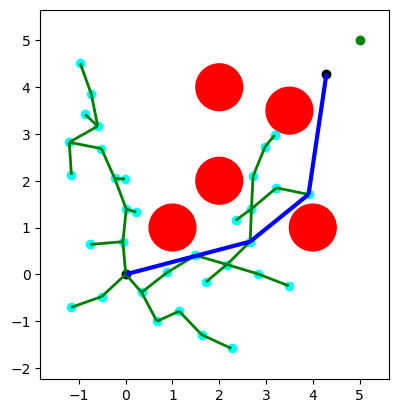

In [11]:
if __name__ == '__main__':
	
	''' Parameters '''
	startpos = (0., 0.) #Latest drone position
	roverpos = (5., 5.) #Latest rover position
	velocity = ([[1], [1]]) #Latest velocity of the rover (global)
	roverRadius = 1 #Distance from the rover that the drone should follow from
	n_iter = 200 #Maximum number of RRT iterations
	stepSize = 0.7 #Length of RRT segments
	
	''' Temporary test obstacles '''
	obstacles = [(1., 1.), (2., 2.), (3.5, 3.5), (2, 4), (4, 1)]
	radius = 0.5

	endpos = getEndpos(obstacles, velocity, roverpos, roverRadius)

	G = RRT(startpos, endpos, obstacles, n_iter, radius, stepSize)

	if G.success:
		path = dijkstra(G)
		path = simplify_path(path, obstacles, radius)
		print(path)
		plot(G, obstacles, radius, roverpos, path)
	else:
		plot(G, obstacles, radius)